 <span style="font-size:2em;font-family:Calibri"> **AUTOMATED ESSAY GRADER** </span>
 
*INTRODUCTION*

Automated essay graders are used by a number of testing services in order to reduce the dependency on human resources in the grading process. Standardized tests, which are taken by large numbers of people and tend to have a predetermined and consistent format are especially suitable for this type of technology.

Education Testing Service (ETS) is perhaps the most well-known of these testing services, and it uses a trademark 'e-rater' technology to grade the Analytical Writing Measure of the Graduate Record Examinations (GRE). According to ETS, this technology extracts certain features representative of writing quality that not only predict scores accurately, but also have a 'logical correspondence to the features that readers are instructed to consider when they award scores'. The score for every GRE essay is the average of the scores of one human grader and the scoring engine; if these two scores differ by more than one point (out of six), the essay is scored by another human grader and that score is used to compute the average instead of the scoring engine's score. The features currently included in the scoring engine are:

- content analysis based on vocabulary measures
- lexical complexity/diction
- proportion of grammar errors
- proportion of usage errors
- proportion of mechanics errors
- proportion of style comments
- organization and development scores
- features rewarding idiomatic phraseology

As can be seen, none of these features actually assess the analytical merits of the essay directly. The goal of this project is to implement a scoring algorithm based on this method and as many of these features as possible to try and see what accuracy can be reached.

There is a large data set of graded essays that was uploaded onto the predictive modeling and analytics platform Kaggle by the William Flora Hewlett Foundation about six years ago as part of a competition to find the best automated scoring algorithm. The data consists of eight essay sets with between 1000-3000 essays in each set, and the rubrics for grading the essays. Each essay is about 100-550 words long. Some of the essays are more dependent on a particular source text than others, and the rubrics reflect this in their grade brackets. The data for each essay set consists of the essays themselves, one or more scores for each essay (the score ranges are different across the essay sets) and a resolved score if there is more than one score. This is the data that will be used to train this essay grader algorithm. The input data for the grader would be entire essays (and their corresponding question prompts) and the output would be scores.

Because the data set consists of vastly different essay sets with different scoring bands and rubrics, only two of these essay sets that have similar scoring bands (0-4) are being used for the purposes of this project.

What follows is the code for training and testing the grading algorithm.

*IMPORTING REQUIRED PACKAGES*

In [2]:
from nltk.corpus import stopwords,words,brown
from nltk import word_tokenize, sent_tokenize, pos_tag
from string import punctuation
import csv
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
import numpy as np
import math
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

*OPENING REQUIRED INPUT FILES*

This is the input data, consisting of the original csv file with the data and the relevant prompts for each question. Only essay sets 5 and 6 are going to be used.

In [3]:
all_essays = open('/data/training_set_rel3.csv',encoding='iso-8859-1')
prompt_5 = open('/data/prompt_5.txt',encoding = 'iso-8859-1').read()
prompt_6 = open('/data/prompt_6.txt',encoding = 'iso-8859-1').read()

*DATA PREPROCESSING*

This is essentially the extraction of what is to go into the algorithm as input: *set_inp* - a list consisting of (1) scores, (2) essays without English stop words, (3) original essays and (4) essay set number, *prompts* - a list of of the prompt passages in the questions for the various essay sets (with the possiblity to include prompts for all questions at every index), and *word_set* - corpus of English words to check spelling errors against.

In [4]:
stops = set(stopwords.words("english"))
read_all_essays = csv.reader(all_essays)
set_inp = []
for row in read_all_essays:
    if row[1] == '5' or row[1] == '6':
        essay_withoutstopwords = [word.lower() for word in word_tokenize(row[2]) if word.lower() not in stops and word not in punctuation]
        essay = row[2].lower()
        score = row[6]
        setno = int(row[1])
        set_inp.append([score,essay_withoutstopwords,essay,setno])
word_list = brown.words()
word_set = set(word_list)
prompts = [0,0,0,0,0,prompt_5,prompt_6]

*FUNCTIONS FOR FEATURE AND CLASS EXTRACTION*

The *featurizer* function is where all the relevant features of the text are extracted, and the *classizer* function extracts the gold standard classes.

The features that I am extracting for each essay include:

- Comparison score between the full essay and the prompt for the corresponding essay set based on tf-idf scores
- uni-, bi- and trigrams in the full essay and their corresponding tf-idf scores
- Top 40 words used in the essay (this number of words seems to boost the results slightly)
- POS tags used in the full essay and their counts
- Lexical density, i.e. count of important POS tags like those for nouns, adjectives and adverbs/all tags
- Word count, character count, sentence count, paragraph count, number of spelling errors converted into z-scores
- Type-token ratio, i.e. number of unique words in text/total number of words

In [5]:
def featurizer(set_input,prompt_input, word_set):
    
    features = []
    
    #GENERATION OF TF-IDF SCORES OF UNI-,BI- AND TRIGRAMS
    tfidf_vect = TfidfVectorizer(min_df=1)
    corpus = [item[2] for item in set_input]
    tf = TfidfVectorizer(analyzer='word', ngram_range=(1,3), min_df = 0, stop_words = 'english')
    tfidf_matrix =  tf.fit_transform(corpus)
    feature_names = tf.get_feature_names() 
    dense = tfidf_matrix.todense()
    
    #FUNCTION TO GENERATE Z-SCORES
    scaler = StandardScaler()
    
    #COUNTER TO AVOID LENGTH ERROR IN TF-IDF MATRIX
    element = 0
    
    
    #LOOPING THROUGH ESSAYS
    for essay in set_input:
        feature_dictionary = {}
        
        #SIMILARITY SCORE BETWEEN ESSAY AND PROMPT
        prompt = prompt_input[essay[3]]
        tfidf = tfidf_vect.fit_transform([prompt,essay[2]])
        pairwise = tfidf * tfidf.T
        sim = 'sim#' + str(round(pairwise[0,1],1))
        feature_dictionary['sim'] = round(pairwise[0,1],1)
        
        #TF-IDF SCORES OF UNI-,BI- AND TRIGRAMS
        if len(dense) > element:
            current_essay = dense[element].tolist()[0]
            phrase_scores = [pair for pair in zip(range(0, len(current_essay)), current_essay) if pair[1] > 0]
            for i in phrase_scores:
                tf = 'tf#' + str(i[0])
                feature_dictionary[tf] = i[1]
        element += 1
        
        #TOP 40 WORDS
        sorted_top = sorted(Counter(essay[1]), key=Counter(essay[1]).get, reverse=True)[:40]
        for i in sorted_top:
            top = 'top#' + i
            feature_dictionary[top] = 1
        
        #COUNTS OF POS TAGS
        pos_tagged = pos_tag(word_tokenize(essay[2]))
        pos_counts = {}
        important_lexical_items = 0
        all_items = 0
        for item in pos_tagged:
            if item[1] in pos_counts:
                pos_counts[item[1]] += 1
            else:
                pos_counts[item[1]] = 1
            if item[1] in ['JJ', 'JJR', 'JJS', 'NN', 'NNS', 'RB', 'RBR', 'RBS']:
                important_lexical_items += 1
            all_items += 1
        for key, value in pos_counts.items():
            feature_dictionary['POS#' + str(key)] = value 
        
        #LEXICAL DENSITY
        feature_dictionary['lexical_density#'] = important_lexical_items/all_items
        
        #WORD COUNT
        word_count = len(word_tokenize(essay[2]))
        feature_dictionary['wc'] = word_count
        
        #CHARACTER COUNT
        character_count = len(essay[2])
        feature_dictionary['cc'] = character_count
        
        #WORD LENGTH
        word_length = np.average([len(word) for word in word_tokenize(essay[2])])
        feature_dictionary['wl'] = word_length
        
        #SENTENCE COUNT
        sentence_count = len(sent_tokenize(essay[2]))
        feature_dictionary['sc'] = sentence_count
        
        #SENTENCE LENGTH
        avg_sentence_length = np.average([len(sentence.split()) for sentence in sent_tokenize(essay[2])])
        feature_dictionary['sl'] = avg_sentence_length
        
        #PARAGRAPH COUNT
        paragraph_count = len(essay[2].split('\n'))
        feature_dictionary['pc'] = paragraph_count
        
        #NUMBER OF SPELLING ERRORS
        spelling_errors = 0
        for word in essay[2].split():
            if word not in word_set:
                spelling_errors += 1
        feature_dictionary['se'] = spelling_errors
        features.append(feature_dictionary)
        
        #TYPE-TOKEN RATIO
        words_list = []
        unique_words = 0
        for word in essay[2].split():
            if word not in words_list:
                unique_words += 1
                words_list.append(word)
        feature_dictionary['ttr'] = unique_words/word_count

    
    #STANDARD-SCALING NUMERICAL FEATURES AND REPLACING THEM
    
    #LISTS OF ALL ELEMENTS FOR EVERY FEATURE
    word_count_list = []
    character_count_list = []
    word_length_list = []
    sentence_count_list = []
    avg_sentence_length_list = []
    paragraph_count_list = []
    spelling_errors_list = []
    
    for item in features:
        word_count_list.append(item['wc'])
        character_count_list.append(item['cc'])
        word_length_list.append(item['wl'])
        sentence_count_list.append(item['sc'])
        avg_sentence_length_list.append(item['sl'])
        paragraph_count_list.append(item['pc'])
        spelling_errors_list.append(item['se'])
        
    #SCALING EACH LIST
    scaled_word_counts = scaler.fit_transform(word_count_list)
    scaled_character_counts = scaler.fit_transform(character_count_list)
    scaled_word_lengths = scaler.fit_transform(word_length_list)
    scaled_sentence_counts = scaler.fit_transform(sentence_count_list)
    scaled_sentence_lengths = scaler.fit_transform(avg_sentence_length_list)
    scaled_paragraph_counts = scaler.fit_transform(paragraph_count_list)
    scaled_spelling_errors = scaler.fit_transform(spelling_errors_list)
    
    #REPLACING VALUES IN FEATURE LIST WITH SCALED ONES
    j = 0
    for wc in scaled_word_counts:
        features[j]['wc'] = wc
        j += 1
    j = 0
    for cc in scaled_character_counts:
        features[j]['cc'] = cc
        j += 1
    j = 0
    for wl in scaled_word_lengths:
        features[j]['wl'] = wl
        j += 1
    j = 0
    for sc in scaled_sentence_counts:
        features[j]['sc'] = sc
        j += 1
    j = 0
    for sl in scaled_sentence_lengths:
        features[j]['sl'] = sl
        j += 1
    j = 0
    for pc in scaled_paragraph_counts:
        features[j]['pc'] = pc
        j += 1
    j = 0
    for se in scaled_spelling_errors:
        features[j]['se'] = se
        j += 1
    return features
    


def classizer(input_set): #to get classes   
    classes = [l[0] for l in input_set]
    return classes


*SPLITTING DATA, STORING VECTORIZED FEATURES AND ALSO CLASSES*

In [6]:
set_inp_train, set_inp_test = train_test_split(set_inp, test_size=0.1, random_state=1)

vectorizer = DictVectorizer(sparse = True)

features_train = vectorizer.fit_transform(featurizer(set_inp_train,prompts,word_set)) #vectorizing feature dictionary

classes_train = classizer(set_inp_train)

C:\Users\Abhishek\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Users\Abhishek\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Users\Abhishek\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a s

*TRAINING AND TESTING ALGORITHM*

The type of classifier used is Support Vector Machine (SVM). Two types of accuracies are calculated: one strict accuracy, which measures how many predicted classes matched the actual classes exactly, and one lenient accuracy, which allows for an error of 1 point.

C:\Users\Abhishek\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Users\Abhishek\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Users\Abhishek\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a s

The strict accuracy of this classifier is 54.57%.
The lenient accuracy of this classifier is 96.68%. A confusion matrix is below.


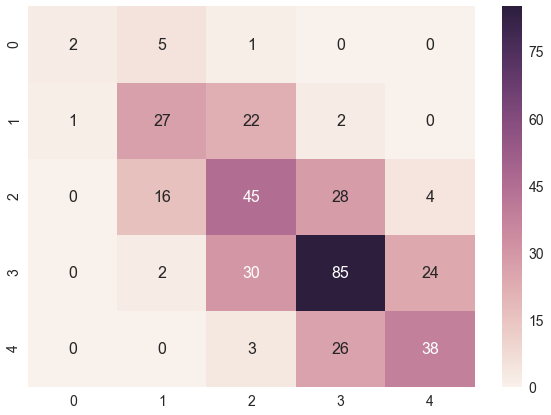

In [7]:
classifier = svm.LinearSVC()

classifier.fit(features_train,classes_train)

features_test = vectorizer.transform(featurizer(set_inp_test,prompts,word_set))

classes_test = classizer(set_inp_test)

predicted_classes = classifier.predict(features_test) #predicting classes for test set

acc = accuracy_score(classes_test, predicted_classes)*100 #accuracy of predicted classes

print('The strict accuracy of this classifier is ' + str(("%.2f" % acc)) + '%.')

total = 0
correct = 0
for output in zip(classes_test,predicted_classes):
    if (int(output[0]) + 1) == int(output[1]) or (int(output[0]) - 1) == int(output[1]) or output[0] == output[1]:
        correct += 1
    total += 1
    
accur = correct*100/total

print('The lenient accuracy of this classifier is ' + str(("%.2f" % accur)) + '%. A confusion matrix is below.')

#CONFUSION MATRIX
array = confusion_matrix(classes_test,predicted_classes)      
df_cm = pd.DataFrame(array, range(5),range(5))
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16})#font size
plt.show()


*CONCLUSION*

As can be seen, the accuracy of the algorithm is less than 60% when using a strict one-to-one method of evaluating the predicted classes against the actual, but a more 'lenient' reading gives a high accuracy. The confusion matrix shows that most essays were either rated accurately or very close to the gold class, which is a reassuring result. With essays rated on a six-point scale like on the GRE we might see a somewhat lower lenient accuracy (such data is not available in this data set), but it would nevertheless be quite high.

During the process of feature engineering, using only basic text metrics such as word count and sentence length in the classifier seemed to make the classifier perform slightly better than chance. It was the POS tags and tf-idf scores that boosted the accuracy significantly. The fact that a high lenient accuracy was obtained, going by the GRE scoring method, shows that to some extent automated essay scoring can be done quite successfully just with features such as the ones used here that act as proxies for semantic difficulty and syntactic complexity, without any regard for the actual analytical merit of the essay.

Of course, the limited diversity of data poses a key problem here. It is inevitable that this classifier picked up on features specific to the two essay prompts used in the input. It would be ideal to use essays graded on the same scale from a range of different topics and answering a range of different questions to train the algorithm. This might yield a better trained classifier that would be more attuned to good writing regardless of subject matter, and would be a good improvement on this work if such data could be found.